In [5]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

![image.png](../assets/data_prep_wf.png)

# Raw Data - FER2013
* 48 X 48 gray scale images
* 28,709 training samples
* 3,589 validation data
* 3,589 test data
* 7 emotion labels (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
* ~60-65% human accuracy in labelling

![image.png](../assets/test_raw_data.png)


https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data


# Data Preparation is Critical
* State of the Art accuracy using a Convolutional Neural Network (CNN) model directly on this raw data is **63%** [1].
* State of the Art accuracy using a slightly modified Convolutional Neural Network (CNN) model after processing the data is **83%** [2].

## Process Data - FER+

* FER+ has new corrected labels that are crowd sourced
* FER+ has 8 emotions - (0: 'neutral', 1: 'happiness', 2: 'surprise', 3: 'sadness', 4: 'anger', 5: 'disgust', 6: 'fear',7: 'contempt')

## Image augmentations:
    * Crop faces in the images – bounding box in the FER+ dataset
    * Scale image size from 48 X 48 -> 64 X 64
    * Shift image
    * Flip image
    * Rotate (angle) image
    * Normalize the pixels in the image

To preprocess follow the instructions listed in the README file - https://github.com/TalkAI/facial-emotion-recognition-gluon#step-1---data-preparation

| Emotion  | Train  | Val  |  Test |
|---|---|---|---|
| neutral  |8733   |  1180 | 1083  |
| happiness  | 7284  | 862  | 892  |
| surprise  | 3136  | 411  | 394  |
| sadness  | 3022  | 348  | 382  |
| anger  | 2098  |  289 |  269 |
| disgust  | 116  | 25  | 16  |
| fear  | 536  | 60  | 86  |
| comtempt  | 120  | 16  | 15  |

In [6]:
# 8 Emotions we want to recognize
emotion_table = {0: 'neutral',
                 1: 'happiness',
                 2: 'surprise',
                 3: 'sadness',
                 4: 'anger',
                 5: 'disgust',
                 6: 'fear',
                 7: 'contempt'}

In [7]:
processed_train_images = np.load('../data/fer_train_processed_images.npy')
processed_train_labels = np.load('../data/fer_train_processed_labels.npy')

In [8]:
print(processed_train_images.shape, processed_train_labels.shape)

(25045, 1, 64, 64) (25045, 8)


In [9]:
from matplotlib import pyplot as plt

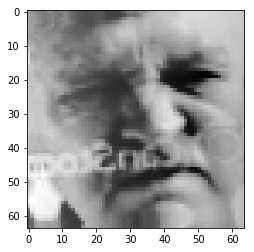

In [10]:
plt.imshow(processed_train_images[987].reshape(64,64), cmap='gray')

In [11]:
processed_test_images = np.load('../data/fer_test_processed_images.npy')
processed_test_labels = np.load('../data/fer_test_processed_labels.npy')
processed_val_images = np.load('../data/fer_val_processed_images.npy')
processed_val_labels = np.load('../data/fer_val_processed_labels.npy')

In [12]:
print(processed_test_images.shape, processed_test_labels.shape)

(3137, 1, 64, 64) (3137, 8)


In [13]:
print(processed_val_images.shape, processed_val_labels.shape)

(3191, 1, 64, 64) (3191, 8)


In [14]:
# Sets context to GPU, if available. Otherwise sets to CPU.
# Note that training on one GPU takes approx. 1.1 minute per epoch, and may take longer on CPU

ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

![image.png](../assets/model_training_prep_wf.png)

# Step 1 – Construct the Neural Network

### 13 layer VGGNet presented in the paper [2]
![image.png](../assets/network.png)

In [15]:
# We use HybridSequential network type to able to save the trained model as symbols and params.
# More Info - https://mxnet.incubator.apache.org/tutorials/gluon/save_load_params.html
net = gluon.nn.HybridSequential()

# Construct 13 layer VGGNet suggested in the paper
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(1024, activation='relu'))
    net.add(gluon.nn.Dropout(0.5))
    net.add(gluon.nn.Dense(1024, activation='relu'))
    net.add(gluon.nn.Dropout(0.5))
    net.add(gluon.nn.Dense(8))

In [16]:
# We Hybridize the HybridSequential network to able to save the trained model as symbols and params.
# More Info - https://mxnet.incubator.apache.org/tutorials/gluon/save_load_params.html
net.hybridize()

# Step 2 – Initialize the parameters in Neural Network

In [17]:
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
nd.waitall()

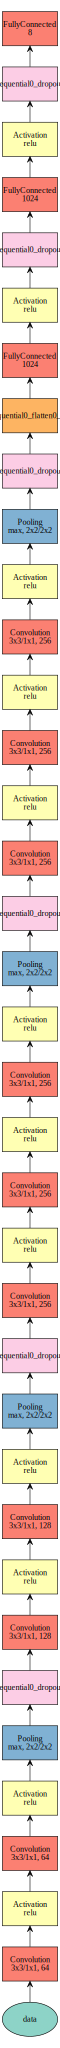

In [18]:
# Use MXBOARD here to visualize network
x = mx.sym.var('data')
sym = net(x)
mx.viz.plot_network(sym)


# Step 3 – Prepare the Trainer with optimizer

In [19]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [20]:
batch_size = 32
trainer = gluon.Trainer(net.collect_params(), 'sgd', 
                        {'learning_rate': 0.0025, 'momentum': 0.9})

# Step 4 – Prepare the model evaluation strategy

In [17]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

# Step 5 – Prepare data loaders

In [18]:
train_labels = np.argmax(processed_train_labels, axis=1)
val_labels = np.argmax(processed_val_labels, axis=1)

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_train_images, train_labels), batch_size = batch_size, shuffle=True)
val_data = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_val_images, val_labels), batch_size = batch_size)


# Step 6 – Train the Neural Network

In [19]:
epochs = 25

train_accuracies = []
losses = []
val_accuracies = []

for e in range(epochs):
    batch = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
            
        loss.backward()
        trainer.step(data.shape[0])
        curr_loss = nd.mean(loss).asscalar()
        batch +=1        

    val_accuracy = evaluate_accuracy(val_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    
    losses.append(curr_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print("Epoch %s. Loss: %s, Train_acc %s, Val_acc %s" % (e, curr_loss, train_accuracy, val_accuracy))

Epoch 0. Loss: 1.4566, Train_acc 0.348692353763, Val_acc 0.369790034472
Epoch 1. Loss: 1.50656, Train_acc 0.360191655021, Val_acc 0.3860858665
Epoch 2. Loss: 1.58091, Train_acc 0.411898582551, Val_acc 0.434033218427
Epoch 3. Loss: 1.3885, Train_acc 0.464404072669, Val_acc 0.478533375118
Epoch 4. Loss: 1.33469, Train_acc 0.50916350569, Val_acc 0.522406769038
Epoch 5. Loss: 1.52856, Train_acc 0.54573767219, Val_acc 0.563773111877
Epoch 6. Loss: 1.18487, Train_acc 0.601836693951, Val_acc 0.621748668129
Epoch 7. Loss: 1.19979, Train_acc 0.652146136953, Val_acc 0.673143215293
Epoch 8. Loss: 0.645745, Train_acc 0.68392892793, Val_acc 0.700094014416
Epoch 9. Loss: 0.888451, Train_acc 0.664563785187, Val_acc 0.673456596678
Epoch 10. Loss: 1.05236, Train_acc 0.709443002595, Val_acc 0.722030711376
Epoch 11. Loss: 0.651695, Train_acc 0.751048113396, Val_acc 0.746161078032
Epoch 12. Loss: 0.900181, Train_acc 0.748852066281, Val_acc 0.744907552491
Epoch 13. Loss: 0.395999, Train_acc 0.76338590537, 

# Step 7 - Evaluate on Test Data

In [20]:
# Test accuracy

acc = mx.metric.Accuracy()
test_labels = np.argmax(processed_test_labels, axis=1)
data_iterator = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_test_images, test_labels), batch_size = 32)
for i, (data, label) in enumerate(data_iterator):
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    output = net(data)
    predictions = nd.argmax(output, axis=1)
    acc.update(preds=predictions, labels=label)
print("Test Accuracy - ", acc.get()[1])

Test Accuracy -  0.795664647753


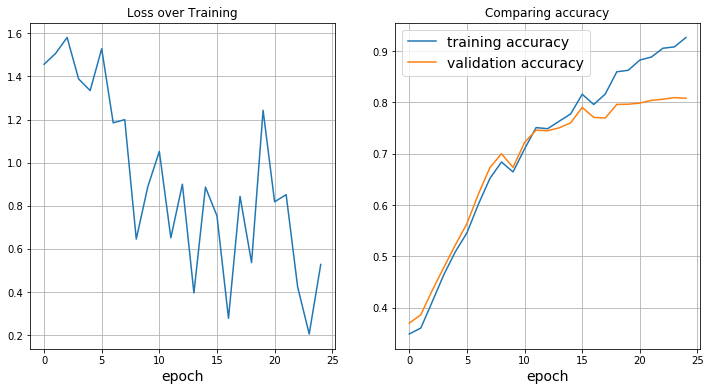

In [21]:
# for plotting purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

epochs = range(len(train_accuracies))

f = plt.figure(figsize=(12,6))
fg1 = f.add_subplot(121)
fg2 = f.add_subplot(122)

fg1.set_xlabel('epoch',fontsize=14)  
fg1.set_title('Loss over Training')
fg1.grid(True, which="both")
fg1.plot(epochs, losses)

fg2.set_title('Comparing accuracy')
fg2.set_xlabel('epoch', fontsize=14)
fg2.grid(True, which="both")

p1, = fg2.plot(epochs, train_accuracies)
p2, = fg2.plot(epochs, val_accuracies)
fg2.legend([p1, p2], ['training accuracy', 'validation accuracy'],fontsize=14)

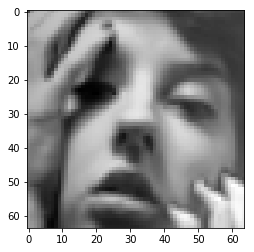

In [22]:
# Example Inference
idx = 98
plt.imshow(processed_test_images[idx].reshape(64,64), cmap='gray')

In [23]:
print("Actual Emotion - ", emotion_table[test_labels[idx]])

Actual Emotion -  sadness


In [24]:
# Perform Inference
output = net(mx.nd.array(processed_test_images[idx].reshape(1,1,64,64)).as_in_context(ctx))

In [25]:
print("Predicted Emotion - ", emotion_table[nd.argmax(output, axis=1).asnumpy()[0]])

Predicted Emotion -  sadness


![image.png](../assets/inference_wf.png)

# Step 8 - Export the model for Production

In [27]:
# Export the model for production deployment.
# There will be 2 files exported: 
# 1) gluon_ferplus-symbol.json => Contains the network definition
# 2) gluon_ferplus-0000.params => Contains the weights in the network
net.export('gluon_ferplus')

# Step 9 - Install pre-requisites for model serving

We will need the PyPi packages listed below to test model server locally, and to perform image pre-processing prior to the model inference.

In [28]:
!pip install mxnet-model-server
!pip install scikit-image
!pip install opencv-python

    100% |████████████████████████████████| 61kB 10.2MB/s ta 0:00:01
    100% |████████████████████████████████| 6.7MB 7.2MB/s eta 0:00:01
  Running setup.py bdist_wheel for importlib2 ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/02/49/20/3add1cc766cc8896e34b40c29e8854a02eeeed422477b811dc
Successfully built importlib2
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Step 10 - Export a model archive

We will now prepare the model archive, which encapsulates all of the resources required by MMS for serving the model. To learn more about the model archive, visit [MMS Export docs](https://github.com/awslabs/mxnet-model-server/blob/master/docs/export.md).

In [29]:
# As a first step, we will download the pre-trained model. 
# You can skip this step if you have just trained your model, but then you will need to copy the model files into ferplus directory
!mkdir ferplus
%cd ferplus
!curl -O https://s3.amazonaws.com/mxnet-demo-models/models/fer/gluon_ferplus-0000.params
!curl -O https://s3.amazonaws.com/mxnet-demo-models/models/fer/gluon_ferplus-symbol.json

/home/ec2-user/SageMaker/facial-emotion-recognition-gluon/notebooks/ferplus
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33.4M  100 33.4M    0     0  68.1M      0 --:--:-- --:--:-- --:--:-- 68.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16867  100 16867    0     0  26773      0 --:--:-- --:--:-- --:--:-- 26773


In [30]:
# Now let's pull in and review the other resources needed for the model archive
%cp ../../model_archive_resources/* .

In [31]:
# We define the model's input and output type and shape via signature.json
!cat signature.json

{
  "input_type": "image/jpeg", 
  "inputs": [
    {
      "data_shape": [1, 1, 64, 64], 
      "data_name": "data"
    }
  ], 
  "outputs": [
    {
      "data_shape": [1, 8],
      "data_name": "hybridsequential0_dense2_fwd"
    }
  ], 
  "output_type": "application/json"
}

In [32]:
# We define the model's class label names via synset.txt
!cat synset.txt

neutral
happiness
surprise
sadness
anger
disgust
fear
contempt

In [33]:
# And lastly, we define custom code for request handling via python code other auxiliary files
!cat fer_service.py

import numpy as np
from mms.utils.mxnet import image
from mms.model_service.mxnet_model_service import MXNetBaseService
from skimage import transform
import mxnet as mx
import cv2 as cv

# One time initialization of Haar Cascade Classifier to extract and crop out face
face_detector = cv.CascadeClassifier('haarcascade_frontalface.xml')
# Classifier parameter specifying how much the image size is reduced at each image scale
scale_factor = 1.3
# Classifier parameter how many neighbors each candidate rectangle should have to retain it
min_neighbors = 5

def crop_face(image):
    """Attempts to identify a face in the input image.

    Parameters
    ----------
    image : array representing a BGR image

    Returns
    -------
    array
        The cropped face, transformed to grayscale. If no face found returns None

    """
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    face_roi_list = face_detector.detectMultiScale(gray_image, scale_factor, min_neighbors)
    
    if (len(fac

In [34]:
# Let's package everything up into a Model Archive bundle
!mxnet-model-export --model-name ferplus --service-file-path ./fer_service.py --model-path .
!ls -l ferplus.model

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/skimage/__init__.py:60: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
-rw-rw-r-- 1 ec2-user ec2-user 35984920 Sep 18 11:10 ferplus.model


# Step 11 - Serving the model archive with MXNet Model Server

Now that we have the model archive ready, we can start the server and ask it to setup HTTP endpoints to serve the model, emit real-time operational metrics and more.
To learn more about serving, check out the [MMS Serving docs](https://github.com/awslabs/mxnet-model-server/blob/master/docs/server.md).

In [35]:
# Spawning a new process to run the server
import subprocess as sp
server = sp.Popen("mxnet-model-server --models ferplus=ferplus.model", shell=True)

In [36]:
# Check out the health endpoint
!curl http://127.0.0.1:8080/ping

{
  "health": "healthy!"
}


Now let's make a prediction request with a test image:
![Happiness](../assets/happy.jpg)

In [7]:
!curl -X POST http://127.0.0.1:8080/ferplus/predict -F "data=@../../assets/happy.jpg"

{
  "prediction": [
    {
      "neutral": 0.3882121741771698
    }, 
    {
      "happiness": 0.5335745811462402
    }, 
    {
      "surprise": 0.002491839462891221
    }, 
    {
      "sadness": 0.05849442631006241
    }, 
    {
      "anger": 0.008850697427988052
    }, 
    {
      "disgust": 0.0009525333880446851
    }, 
    {
      "fear": 0.0007643798599019647
    }, 
    {
      "contempt": 0.006659356877207756
    }
  ]
}


In [37]:
# Lastly, we'll terminate the server
server.terminate()

# References
1. I. J. Goodfellow, D. Erhan, P. L. Carrier, A. Courville,
M. Mirza, B. Hamner, W. Cukierski, Y. Tang,
D. Thaler, D.-H. Lee, et al. Challenges in
representation learning: A report on three machine
learning contests. In Neural information processing,
pages 117–124. Springer, 2013

2. Training Deep Networks for Facial Expression Recognition with Crowd-Sourced Label Distribution Emad Barsoum et. al. https://arxiv.org/abs/1608.01041
